In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
from time import gmtime, strftime
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split

import wfdb
#https://github.com/MIT-LCP/wfdb-python
from wfdb import processing

In [5]:
#Beats generation,
#we defined a single ECG beat image by centering the Q-wave peak signal while
#excluding the first and the last 20 ECG signals from the previous and afterward Q-wave peak signal
#https://github.com/MIT-LCP/wfdb-python/blob/master/demo.ipynb
def labeltotext(val):
    if val =='L':
        return 1 #'LBB'
    elif val == 'R':
        return 2 #'RBB'
    elif val == 'V':
        return 3 #'PVC'
    elif val == 'A':
        return 4 #'APC'
    elif val == '/':
        return 5 #'PAB'
    #elif val == '!':
    #    return 6 #'VFW'
    #elif val == 'E':
    #    return 7 #'VEB'
    else:
        return 0 #'NOR'
    
rootdir = '/data/fjsdata/physionet/MIT-BIH/mitdb/'
trunc_len = 90 #length around of peak value of QRS
data = [] #[QRS value, label, lead name]
for bt in range(100,235):#100-234
    file = os.path.join(rootdir,str(bt))
    try:
        annotation = wfdb.rdann(file, 'atr') 
        qrs_spl = annotation.sample #numpy.ndarray
        qrs_sym = annotation.symbol #list
        record = wfdb.rdrecord(file)
        signal = record.p_signal #numpy.ndarray
        max_len = record.sig_len #length of samples
        lead_name =  record.sig_name #names of lead channels,list
        for i in range(annotation.ann_len):
            if qrs_sym[i] in ['N','L','R','V','A','/','!','E']:#seven diseases samples
                pos = qrs_spl[i] #corresponding position of peak value of QRS
                if pos+trunc_len<=max_len and pos-trunc_len>=0:
                    max_idx = pos+trunc_len#np.min([max_len, pos+trunc_len])
                    min_idx = pos-trunc_len#np.max([0, pos-trunc_len])
                    for j, val in enumerate(lead_name):
                        QRS_value = signal[:,j][min_idx:max_idx]
                        data.append([QRS_value,labeltotext(qrs_sym[i]),val])#[QRS value, label, lead name]
    except:
        #print(str(bt)+":"+file)
        pass

#trainset and testset
data = pd.DataFrame(np.array(data))
print(data[1].value_counts())
#plt.hist(data_spl[1]) 
#plt.title("histogram") 
#plt.show()
#data = pd.DataFrame(np.array(data))
#data_dis = data[data[1]!=0] #disease QRS
#data_nor = data[data[1]==0].sample(n=14768, random_state=1)#normal QRS, sample 14768
#data_spl = pd.concat([data_dis,data_nor],axis=0).reset_index(drop=True)
#data_X = pd.DataFrame(data_spl[0].values.tolist()) #split array to multi-columns
#data_Y = data_spl[1]
#X_train, X_test, y_train, y_test = train_test_split( data_X, data_Y, test_size=0.1, random_state=42)

0    151222
1     16146
2     14514
3     14258
5     14054
4      5092
Name: 1, dtype: int64


215286


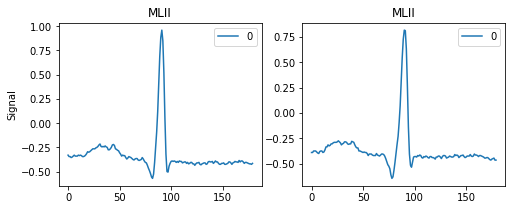

In [9]:
print(len(data))
QRS1 =data[2][0]
QRS1_label = data[2][1]
QRS1_lead = data[2][2]
QRS2 =data[122][0]
QRS2_label = data[122][1]
QRS2_lead = data[122][2]
#plot
plt.figure(figsize=(8,3))
# 1
plt.subplot(1, 2, 1)
x = np.arange(len(QRS1)) 
lsh = plt.plot(x,QRS1,label=QRS1_label)
plt.ylabel('Signal')
plt.title(QRS1_lead)
plt.legend()
# 2
plt.subplot(1, 2, 2)
x = np.arange(len(QRS2)) 
lsh = plt.plot(x,QRS2,label=QRS2_label)
plt.title(QRS2_lead)
plt.legend()

In [63]:
# QRS-P-T detection
file = os.path.join(rootdir,'100')
record = wfdb.rdrecord(file, channels=[0],sampfrom=0, sampto=3600, physical=False)
peaks = processing.gqrs_detect(d_sig=record.d_signal[:,0],
                                       fs=record.fs,
                                       adc_gain=record.adc_gain[0],
                                       adc_zero=record.adc_zero[0],
                                       threshold=1.0)
print (peaks)
#assert np.array_equal(peaks, expected_peaks)

[ 357  650  934 1218 1502 1797 2032 2390 2693 2985 3270]


qrs peaks indices
[]
noise peaks indices
[]


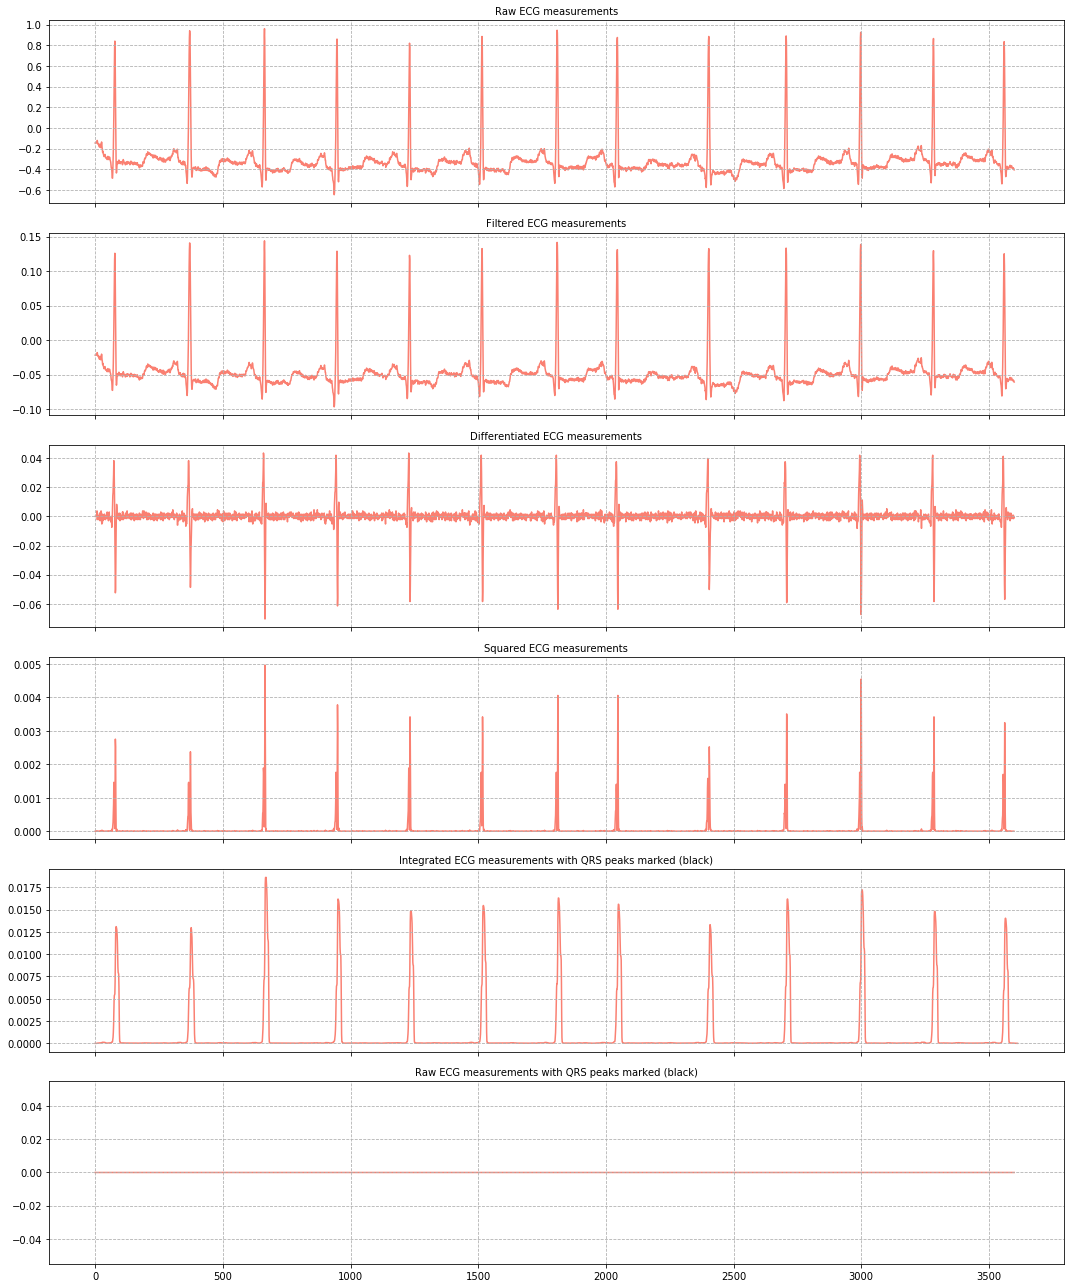

In [53]:
#https://github.com/c-labpl/qrs_detector/blob/master/qrs_detector_offline_example.ipynb
class QRSDetector(object):
    """
    Python Offline ECG QRS Detector based on the Pan-Tomkins algorithm.
    """

    def __init__(self, ecg_data_raw, verbose=True, plot_data=True, show_plot=True):
        """
        QRSDetectorOffline class initialisation method.
        :param numpy array ecg_data_raw: [time, value]
        :param bool verbose: flag for printing the results
        :param bool log_data: flag for logging the results
        :param bool plot_data: flag for plotting the results to a file
        :param bool show_plot: flag for showing generated results plot - will not show anything if plot is not generated
        """
        # Configuration parameters
        self.signal_frequency = 360  # Set ECG device frequency in samples per second here.

        self.filter_lowcut = 0.001#lowcut cannot be zero
        self.filter_highcut = 20.0
        self.filter_order = 1

        self.integration_window = 15  # Change proportionally when adjusting frequency (in samples).

        self.findpeaks_limit = 0.35
        self.findpeaks_spacing = 50  # Change proportionally when adjusting frequency (in samples).

        self.refractory_period = 120  # Change proportionally when adjusting frequency (in samples).
        self.qrs_peak_filtering_factor = 0.125
        self.noise_peak_filtering_factor = 0.125
        self.qrs_noise_diff_weight = 0.25

        # Loaded ECG data.
        self.ecg_data_raw = ecg_data_raw

        # Measured and calculated values.
        self.filtered_ecg_measurements = None
        self.differentiated_ecg_measurements = None
        self.squared_ecg_measurements = None
        self.integrated_ecg_measurements = None
        self.detected_peaks_indices = None
        self.detected_peaks_values = None

        self.qrs_peak_value = 0.0
        self.noise_peak_value = 0.0
        self.threshold_value = 0.0

        # Detection results.
        self.qrs_peaks_indices = np.array([], dtype=int)
        self.noise_peaks_indices = np.array([], dtype=int)

        # Final ECG data and QRS detection results array - samples with detected QRS are marked with 1 value.
        self.ecg_data_detected = None

        # Run whole detector flow.
        self.detect_peaks()
        self.detect_qrs()

        if verbose:
            self.print_detection_data()

        if plot_data:
            #PLOT_DIR = "plots/"
            #self.plot_path = "{:s}QRS_offline_detector_plot_{:s}.png".format(PLOT_DIR,strftime("%Y_%m_%d_%H_%M_%S", gmtime()))
            self.plot_detection_data(show_plot=show_plot)


    """ECG measurements data processing methods."""

    def detect_peaks(self):
        """
        Method responsible for extracting peaks from loaded ECG measurements data through measurements processing.
        """
        # Extract measurements from loaded ECG data.
        ecg_measurements = self.ecg_data_raw

        # Measurements filtering - 0-15 Hz band pass filter.
        self.filtered_ecg_measurements = self.bandpass_filter(ecg_measurements, lowcut=self.filter_lowcut,\
                                                              highcut=self.filter_highcut, signal_freq=self.signal_frequency,\
                                                              filter_order=self.filter_order)
        self.filtered_ecg_measurements[:5] = self.filtered_ecg_measurements[5]

        # Derivative - provides QRS slope information.
        self.differentiated_ecg_measurements = np.ediff1d(self.filtered_ecg_measurements)

        # Squaring - intensifies values received in derivative.
        self.squared_ecg_measurements = self.differentiated_ecg_measurements ** 2

        # Moving-window integration.
        self.integrated_ecg_measurements = np.convolve(self.squared_ecg_measurements, np.ones(self.integration_window))

        # Fiducial mark - peak detection on integrated measurements.
        self.detected_peaks_indices = self.findpeaks(data=self.integrated_ecg_measurements,\
                                                     limit=self.findpeaks_limit,\
                                                     spacing=self.findpeaks_spacing)

        self.detected_peaks_values = self.integrated_ecg_measurements[self.detected_peaks_indices]

    """QRS detection methods."""

    def detect_qrs(self):
        """
        Method responsible for classifying detected ECG measurements peaks either as noise or as QRS complex (heart beat).
        """
        for detected_peak_index, detected_peaks_value in zip(self.detected_peaks_indices, self.detected_peaks_values):

            try:
                last_qrs_index = self.qrs_peaks_indices[-1]
            except IndexError:
                last_qrs_index = 0

            # After a valid QRS complex detection, there is a 200 ms refractory period before next one can be detected.
            if detected_peak_index - last_qrs_index > self.refractory_period or not self.qrs_peaks_indices.size:
                # Peak must be classified either as a noise peak or a QRS peak.
                # To be classified as a QRS peak it must exceed dynamically set threshold value.
                if detected_peaks_value > self.threshold_value:
                    self.qrs_peaks_indices = np.append(self.qrs_peaks_indices, detected_peak_index)

                    # Adjust QRS peak value used later for setting QRS-noise threshold.
                    self.qrs_peak_value = self.qrs_peak_filtering_factor * detected_peaks_value + \
                                          (1 - self.qrs_peak_filtering_factor) * self.qrs_peak_value
                else:
                    self.noise_peaks_indices = np.append(self.noise_peaks_indices, detected_peak_index)

                    # Adjust noise peak value used later for setting QRS-noise threshold.
                    self.noise_peak_value = self.noise_peak_filtering_factor * detected_peaks_value + \
                                            (1 - self.noise_peak_filtering_factor) * self.noise_peak_value

                # Adjust QRS-noise threshold value based on previously detected QRS or noise peaks value.
                self.threshold_value = self.noise_peak_value + \
                                       self.qrs_noise_diff_weight * (self.qrs_peak_value - self.noise_peak_value)

        # Create array containing both input ECG measurements data and QRS detection indication column.
        # We mark QRS detection with '1' flag in 'qrs_detected' log column ('0' otherwise).
        measurement_qrs_detection_flag = np.zeros([len(self.ecg_data_raw), 1])
        measurement_qrs_detection_flag[self.qrs_peaks_indices] = 1
        self.ecg_data_detected = np.append(self.ecg_data_raw, measurement_qrs_detection_flag, 1)

    """Results reporting methods."""

    def print_detection_data(self):
        """
        Method responsible for printing the results.
        """
        print("qrs peaks indices")
        print(self.qrs_peaks_indices)
        print("noise peaks indices")
        print(self.noise_peaks_indices)

    def plot_detection_data(self, show_plot=True):
        """
        Method responsible for plotting detection results.
        :param bool show_plot: flag for plotting the results and showing plot
        """
        def plot_data(axis, data, title='', fontsize=10):
            axis.set_title(title, fontsize=fontsize)
            axis.grid(which='both', axis='both', linestyle='--')
            axis.plot(data, color="salmon", zorder=1)

        def plot_points(axis, values, indices):
            axis.scatter(x=indices, y=values[indices], c="black", s=50, zorder=2)

        plt.close('all')
        fig, axarr = plt.subplots(6, sharex=True, figsize=(15, 18))

        plot_data(axis=axarr[0], data=self.ecg_data_raw, title='Raw ECG measurements')
        plot_data(axis=axarr[1], data=self.filtered_ecg_measurements, title='Filtered ECG measurements')
        plot_data(axis=axarr[2], data=self.differentiated_ecg_measurements, title='Differentiated ECG measurements')
        plot_data(axis=axarr[3], data=self.squared_ecg_measurements, title='Squared ECG measurements')
        plot_data(axis=axarr[4], data=self.integrated_ecg_measurements, title='Integrated ECG measurements with QRS peaks marked (black)')
        plot_points(axis=axarr[4], values=self.integrated_ecg_measurements, indices=self.qrs_peaks_indices)
        plot_data(axis=axarr[5], data=self.ecg_data_detected[:, 1], title='Raw ECG measurements with QRS peaks marked (black)')
        plot_points(axis=axarr[5], values=self.ecg_data_detected[:, 1], indices=self.qrs_peaks_indices)

        plt.tight_layout()
        #fig.savefig(self.plot_path)

        if show_plot:
            plt.show()

        plt.close()

    """Tools methods."""

    def bandpass_filter(self, data, lowcut, highcut, signal_freq, filter_order):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        #https://github.com/scipy/scipy/blob/v0.19.1/scipy/signal/filter_design.py#L2226-L2297
        b, a = butter(filter_order, [low, high], btype="band")
        
        y = lfilter(b, a, data)
        return y

    def findpeaks(self, data, spacing=1, limit=None):
        """
        Janko Slavic peak detection algorithm and implementation.
        https://github.com/jankoslavic/py-tools/tree/master/findpeaks
        Finds peaks in `data` which are of `spacing` width and >=`limit`.
        :param ndarray data: data
        :param float spacing: minimum spacing to the next peak (should be 1 or more)
        :param float limit: peaks should have value greater or equal
        :return array: detected peaks indexes array
        """
        len = data.size
        x = np.zeros(len + 2 * spacing)
        x[:spacing] = data[0] - 1.e-6
        x[-spacing:] = data[-1] - 1.e-6
        x[spacing:spacing + len] = data
        peak_candidate = np.zeros(len)
        peak_candidate[:] = True
        for s in range(spacing):
            start = spacing - s - 1
            h_b = x[start: start + len]  # before
            start = spacing
            h_c = x[start: start + len]  # central
            start = spacing + s + 1
            h_a = x[start: start + len]  # after
            peak_candidate = np.logical_and(peak_candidate, np.logical_and(h_c > h_b, h_c > h_a))

        ind = np.argwhere(peak_candidate)
        ind = ind.reshape(ind.size)
        if limit is not None:
            ind = ind[data[ind] > limit]
        return ind

# QRS-P-T detection
file = os.path.join(rootdir,'100')
spl_len = 360*10#fs=360,times=10s
record = wfdb.rdrecord(file, sampfrom=0, sampto = spl_len, channel_names=['MLII', 'V1']) #fs=360,all 5 seconds
signal = record.p_signal[:,0].reshape(spl_len,1)#one channels
qrs_detector = QRSDetector(ecg_data_raw=signal)

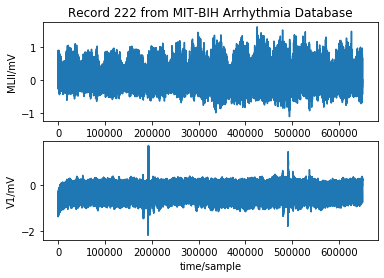

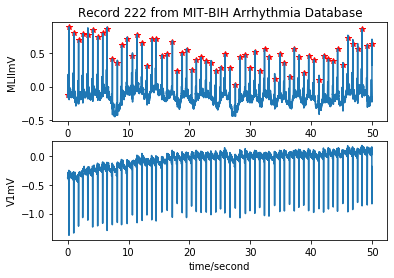

In [57]:
rootdir = '/data/fjsdata/physionet/MIT-BIH/physionet.org/files/mitdb/1.0.0'
# Demo 1 - Read a wfdb record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data.
record = wfdb.rdrecord(os.path.join(rootdir,'222'), sampfrom=0, sampto = 650000, channel_names=['MLII', 'V1']) #100-234
wfdb.plot_wfdb(record=record, title='Record 222 from MIT-BIH Arrhythmia Database') 
#display(record.__dict__)
#print(record.p_signal.shape)
annotation = wfdb.rdann(os.path.join(rootdir,'222'), 'atr')
#print(annotation.sample.shape) #标注每一个心拍的R波的尖锋位置，与心电信号对应
#print(len(annotation.symbol)) #标注每一个心拍的类型N，L，R等等
#print(annotation.ann_len)# 被标注的数量
#print(wfdb.show_ann_labels()) # 查看心拍的类型

# Demo 2 - Read certain channels and sections of the WFDB record using the simplified 'rdsamp' function
# which returns a numpy array and a dictionary. Show the data.
signals, fields = wfdb.rdsamp(os.path.join(rootdir,'222'), channel_names=['MLII', 'V1'], sampfrom=100, sampto=15000)
#display(signals.shape)
#display(fields)
# Demo 3 - Read a WFDB header file only (without the signals)
record = wfdb.rdheader(os.path.join(rootdir,'222'))
#display(record.__dict__)
# Demo 4 - Read part of a WFDB annotation file into a wfdb.Annotation object, and plot the samples
annotation = wfdb.rdann(os.path.join(rootdir,'222'), 'atr', sampfrom=100000, sampto=110000)
#annotation.fs = 360
#wfdb.plot_wfdb(annotation=annotation, time_units='minutes')
# Demo 5 - Read a WFDB record and annotation. Plot all channels, and the annotation on top of channel 0.
record = wfdb.rdrecord(os.path.join(rootdir,'222'), sampto = 18000)
annotation = wfdb.rdann(os.path.join(rootdir,'222'), 'atr', sampto = 18000) #samples:18000=50s*360(fs)
wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record 222 from MIT-BIH Arrhythmia Database',
               time_units='seconds')

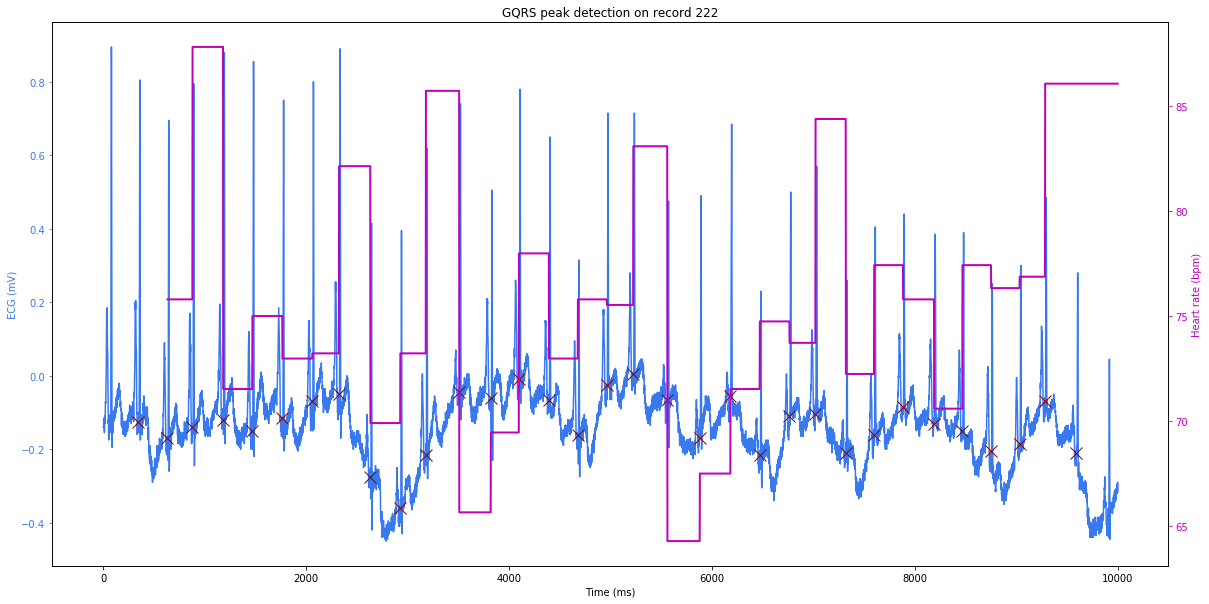

Corrected gqrs detected peak indices: [361, 646, 892, 1194, 1482, 1778, 2072, 2336, 2645, 2940, 3191, 3521, 3832, 4109, 4405, 4690, 4975, 5235, 5572, 5892, 6194, 6483, 6776, 7032, 7332, 7610, 7894, 8200, 8480, 8763, 9044, 9294, 9605]


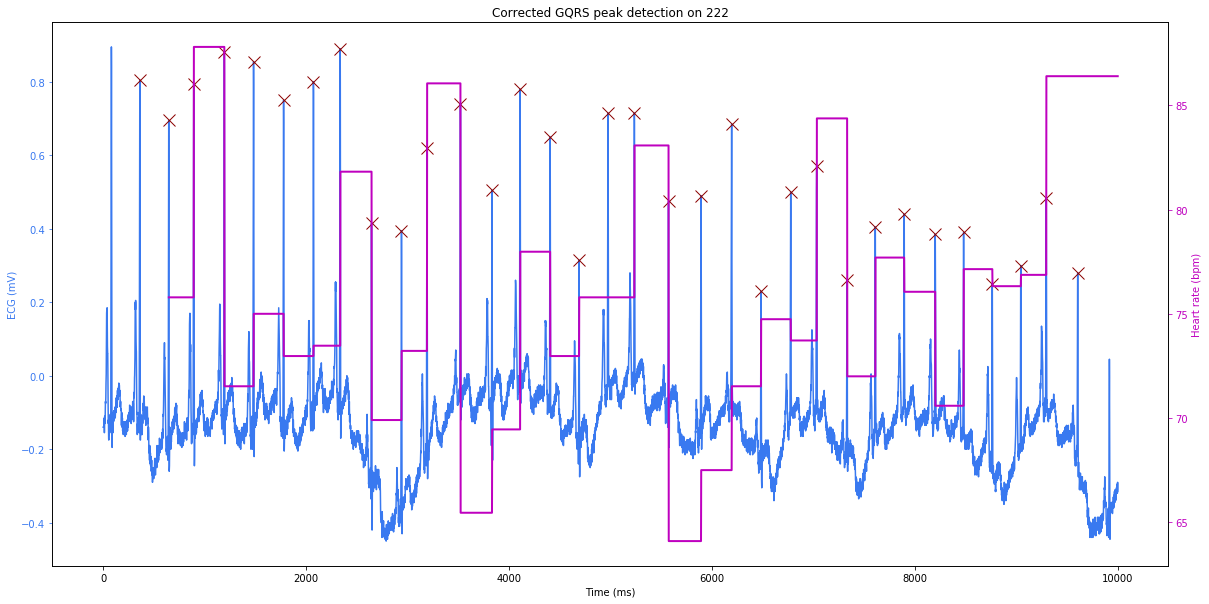

In [51]:
# Demo 19 - Use the gqrs detection algorithm and correct the peaks

def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()

# Load the wfdb record and the physical samples
record = wfdb.rdrecord(os.path.join(rootdir,'222'), sampfrom=0, sampto=10000, channels=[0])

# Use the gqrs algorithm to detect qrs locations in the first channel
qrs_inds = processing.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

# Plot results
peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
        title="GQRS peak detection on record 222")
    
# Correct the peaks shifting them to local maxima
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.correct_peaks(record.p_signal[:,0], peak_inds=qrs_inds,
                                               search_radius=search_radius, smooth_window_size=150)

# Display results
print('Corrected gqrs detected peak indices:', sorted(corrected_peak_inds))
peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected GQRS peak detection on 222")